In [1]:
from common import colors, pvalue_thresholds, insetlw

In [2]:
import os
os.chdir(os.path.join('..', '..', '..'))
print(os.getcwd())

/home/eharkin/projects/5HTGIF-dev


In [3]:
import re

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.gridspec as gs
from mpl_toolkits.axes_grid1.inset_locator import mark_inset
import seaborn as sns
from scipy import stats
from sklearn.manifold import TSNE
from statannot import add_stat_annotation
from ezephys import pltools

In [4]:
plt.style.use(os.path.join('figs', 'scripts', 'writeup', 'publication_figure_style.dms'))

In [5]:
IMG_PATH = os.path.join('figs', 'ims', 'writeup', 'GIF_parameters')

# Load data

In [6]:
params = pd.read_csv(os.path.join('analysis', 'model_clustering', 'model_params.csv'))
print(params.shape)

(156, 37)


In [7]:
params.head()

,C,DV,E_K,El,Tref,Vr,Vt_star,cell_type,dt,eta_10.0,...,lambda0,m_A,m_Vhalf,m_k,n_A,n_Vhalf,n_k,name,resting_potential,type
0,0.099165,6.537423,NaN,-64.456700,6.5,-53.551984,-55.723169,5HT,0.1,0.008590,...,1.0,NaN,NaN,NaN,NaN,NaN,NaN,DRN307,-64.456703,GIF
1,0.121812,4.442023,NaN,-80.402978,6.5,-54.555621,-54.317823,5HT,0.1,0.024262,...,1.0,NaN,NaN,NaN,NaN,NaN,NaN,DRN308,-80.402977,GIF
2,0.115125,2.417979,NaN,-64.851407,6.5,-56.135385,-49.111013,5HT,0.1,0.068537,...,1.0,NaN,NaN,NaN,NaN,NaN,NaN,DRN317,-64.851410,GIF
3,0.094173,3.813900,NaN,-63.565351,6.5,-55.919281,-46.181507,5HT,0.1,0.017409,...,1.0,NaN,NaN,NaN,NaN,NaN,NaN,DRN318,-63.565350,GIF
4,0.105769,4.568117,NaN,-54.186544,6.5,-49.185461,-59.392968,5HT,0.1,0.030981,...,1.0,NaN,NaN,NaN,NaN,NaN,NaN,DRN319,-54.186543,GIF


In [8]:
params.columns

Index([u'C', u'DV', u'E_K', u'El', u'Tref', u'Vr', u'Vt_star', u'cell_type',
       u'dt', u'eta_10.0', u'eta_100.0', u'eta_1000.0', u'eta_3.0',
       u'eta_30.0', u'eta_300.0', u'eta_3000.0', u'gamma_3.0', u'gamma_30.0',
       u'gamma_300.0', u'gamma_3000.0', u'gbar_K1', u'gbar_K2', u'gl', u'h_A',
       u'h_Vhalf', u'h_k', u'h_tau', u'lambda0', u'm_A', u'm_Vhalf', u'm_k',
       u'n_A', u'n_Vhalf', u'n_k', u'name', u'resting_potential', u'type'],
      dtype='object')

# Compute additional features

- Time constant
- Distance to threshold
- Spike triggered current integral
- Spike triggered threshold movement integral

In [9]:
params['thresh_dist'] = params['Vt_star'] - params['resting_potential']
params['time_const'] = params['C'] / params['gl']

In [10]:
def get_kernel_integral(model_param_df, kernel_name):
    integrals = np.zeros(model_param_df.shape[0], dtype=np.float64)
    
    for colname in model_param_df.columns:
        match = re.search('{}_(.*)'.format(kernel_name), colname)
        if match is not None:
            try:
                timescale = float(match.groups()[0])
                integrals += model_param_df[colname] * timescale
            except ValueError:
                pass
    
    return integrals

def _monoexponential_integral(scale, tau, start, end):
    """Evaluate the integral of scale * e^{-t/tau} from t=start to end."""
    return scale * tau * (np.exp(-start / tau) - np.exp(-end / tau))

def get_kernel_integral_over_range(model_param_df, kernel_name, start, end):
    integrals = np.zeros(model_param_df.shape[0], dtype=np.float64)
    
    for colname in model_param_df.columns:
        match = re.search('{}_(.*)'.format(kernel_name), colname)
        if match is not None:
            try:
                timescale = float(match.groups()[0])
                integrals += _monoexponential_integral(model_param_df[colname], timescale, start, end)
            except ValueError:
                # ValueError if match cannot be converted to float.
                pass
    
    return integrals

In [11]:
y = 2 * np.exp(-np.arange(10, 40, 0.1) / 30.)
print(y.sum() * 0.1)
print(_monoexponential_integral(2., 30., 10., 40.))

27.221368927734513
27.17605034748375


In [12]:
params['gamma_integral'] = get_kernel_integral(params, 'gamma')
params['gamma_integral_100_300'] = get_kernel_integral_over_range(params, 'gamma', 100., 300.)
params['eta_integral'] = get_kernel_integral(params, 'eta')
params['eta_integral_100_300'] = get_kernel_integral_over_range(params, 'eta', 100., 300.)

# Select models for each cell type and remove unnecessary features

Based on performance, use
- AugmentdGIF for 5HT
- iGIF for GABA
- GIF for mPFC

In [13]:
params_cleaned = params.copy()
params_cleaned.drop(columns=[
    'Tref', 'dt', 'E_K', 'gbar_K1', 'gbar_K2', 'h_A', 'h_Vhalf', 
    'h_k', 'lambda0', 'm_A', 'm_Vhalf', 'm_k', 'n_A', 'n_Vhalf', 
    'n_k', 'h_tau',
], inplace=True)
params_cleaned = params_cleaned.loc[
    ((params_cleaned['cell_type'] == 'mPFC') & (params_cleaned['type'] == 'GIF'))
    | ((params_cleaned['cell_type'] == '5HT') & (params_cleaned['type'] == 'AugmentedGIF'))
    | ((params_cleaned['cell_type'] == 'GABA') & (params_cleaned['type'] == 'iGIF_NP')),
    :
]
params_cleaned.drop(columns=['name', 'type'], inplace=True)

cell_types = params_cleaned['cell_type']
params_cleaned.drop(columns=['cell_type'], inplace=True)

params_cleaned.head()

,C,DV,El,Vr,Vt_star,eta_10.0,eta_100.0,eta_1000.0,eta_3.0,eta_30.0,...,gamma_300.0,gamma_3000.0,gl,resting_potential,thresh_dist,time_const,gamma_integral,gamma_integral_100_300,eta_integral,eta_integral_100_300
18,0.094361,5.151440,-58.844484,-53.551984,-54.177859,0.017686,0.034300,0.002096,0.049526,-0.008602,...,9.210687,4.043286,0.000861,-63.878241,9.700382,109.628596,172547.065174,1679.887241,7.464355,1.501455
19,0.114845,3.100222,-78.704060,-54.555621,-52.019543,0.031297,0.044008,0.006359,0.075099,-0.015408,...,33.070279,1.567952,0.000922,-80.044693,28.025150,124.519142,16828.467756,3841.221900,5.351770,2.791997
20,0.112719,1.243869,-63.613946,-56.135385,-46.521983,0.070731,0.060428,0.001838,-0.027645,-0.023487,...,10.527019,-0.196059,0.001880,-65.250572,18.728589,59.967890,5389.795788,1177.382551,6.968573,2.615805
21,0.087793,2.370314,-59.092437,-55.919281,-44.941785,0.022294,0.063337,0.001827,-0.016180,-0.006967,...,15.640274,-0.849952,0.001260,-62.917251,17.975466,69.652951,2565.942361,1494.445527,7.327677,2.056429
22,0.121158,4.977856,-50.061295,-49.185461,-58.738916,0.048414,0.021002,0.005247,-0.085554,0.010993,...,0.173663,2.356287,0.001390,-50.061295,-8.677622,87.132521,10313.230576,451.370729,-6.387377,0.578642


In [14]:
print(params_cleaned.columns)

Index([u'C', u'DV', u'El', u'Vr', u'Vt_star', u'eta_10.0', u'eta_100.0',
       u'eta_1000.0', u'eta_3.0', u'eta_30.0', u'eta_300.0', u'eta_3000.0',
       u'gamma_3.0', u'gamma_30.0', u'gamma_300.0', u'gamma_3000.0', u'gl',
       u'resting_potential', u'thresh_dist', u'time_const', u'gamma_integral',
       u'gamma_integral_100_300', u'eta_integral', u'eta_integral_100_300'],
      dtype='object')


In [15]:
print(params_cleaned.shape)

(39, 24)


In [16]:
params_cleaned.groupby(cell_types).mean().loc[:, [
    'thresh_dist', 'time_const', 'gamma_integral', 'gamma_integral_100_300', 'eta_integral', 'eta_integral_100_300'
]]

,thresh_dist,time_const,gamma_integral,gamma_integral_100_300,eta_integral,eta_integral_100_300
cell_type,,,,,,
5HT,15.104393,82.605473,8.435214e+06,121346.071593,6.165346,2.113692
GABA,7.486579,37.816230,7.953363e+02,159.205748,0.215101,0.069758
mPFC,3.977571,41.955724,8.707739e+02,60.442295,2.747578,0.146596


In [17]:
params_cleaned.groupby(cell_types).median().loc[:, [
    'thresh_dist', 'time_const', 'gamma_integral', 'gamma_integral_100_300', 'eta_integral', 'eta_integral_100_300'
]]

,thresh_dist,time_const,gamma_integral,gamma_integral_100_300,eta_integral,eta_integral_100_300
cell_type,,,,,,
5HT,16.373741,81.205174,10427.344125,1417.645199,6.931264,2.145208
GABA,8.730338,34.141340,444.253968,121.665851,-0.083192,0.029879
mPFC,8.402660,30.006071,604.657659,44.120746,2.665248,0.310253


In [18]:
params_cleaned.groupby(cell_types).std().loc[:, [
    'thresh_dist', 'time_const', 'gamma_integral', 'gamma_integral_100_300', 'eta_integral', 'eta_integral_100_300'
]]

,thresh_dist,time_const,gamma_integral,gamma_integral_100_300,eta_integral,eta_integral_100_300
cell_type,,,,,,
5HT,9.853692,30.984394,2.165077e+07,506367.956224,4.314922,0.924551
GABA,9.355018,21.807854,7.796334e+02,149.337098,2.084112,0.355123
mPFC,10.266718,34.308788,7.180134e+02,47.757383,1.832729,0.434836


In [19]:
params_cleaned.groupby(cell_types).count().loc[:, [
    'thresh_dist', 'time_const', 'gamma_integral', 'gamma_integral_100_300', 'eta_integral', 'eta_integral_100_300'
]]

,thresh_dist,time_const,gamma_integral,gamma_integral_100_300,eta_integral,eta_integral_100_300
cell_type,,,,,,
5HT,18,18,18,18,18,18
GABA,14,14,14,14,14,14
mPFC,7,7,7,7,7,7


# Functions for rescaling variables

In [20]:
def rescale_variables(x):
    """Subtract mean and normalize to SD for each column of a dataframe or array.
    Returns a copy.
    """
    output = x.copy()
    
    try:
        # Method for pd.DataFrames
        output.iloc # Test if x is DataFrame-like
        
        for colname in output:
            output[colname] = output[colname] - np.mean(output[colname])
            output[colname] = output[colname] / np.std(output[colname])
    
    except AttributeError:
        # Method for np.arrays.
        output[0, 0] # Test if x is array-like
        
        output -= output.mean(axis = 0)
        output /= output.std(axis = 0)
        
    return output

In [21]:
def rescale_variables_nonparametric(x):
    """Subtract median and divide by interquartile range for each column of x."""
    output = x.copy()
    
    try:
        # Method for pd.DataFrames
        output.iloc # Test if x is DataFrame-like
        
        for colname in output:
            output[colname] = output[colname] - np.median(output[colname])
            output[colname] = output[colname] / stats.iqr(output[colname])
    
    except AttributeError:
        # Method for np.arrays.
        output[0, 0] # Test if x is array-like
        
        output -= output.median(axis = 0)
        output /= stats.iqr(output, axis=0)
        
    return output

In [22]:
rescaled = rescale_variables_nonparametric(params_cleaned)

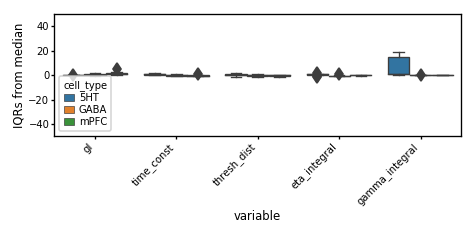

In [23]:
plt.figure(figsize=(4, 2))
sns.boxplot(
    x='variable', y='value', hue='cell_type', 
    data=pd.concat([rescaled, cell_types], axis=1).melt(id_vars='cell_type'),
    order = ['gl', 'time_const', 'thresh_dist', 'eta_integral', 'gamma_integral']
)
plt.ylim(-50, 50)
tick_locs, tick_labs = plt.xticks()
plt.xticks(*plt.xticks(), rotation=45, ha='right')
plt.ylabel('IQRs from median')
plt.tight_layout()

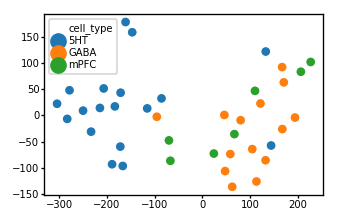

In [24]:
tsne = TSNE(perplexity=7, random_state=43)
projected = tsne.fit_transform(rescaled.loc[:, ['time_const', 'thresh_dist', 'eta_integral', 'gamma_integral']])

sns.scatterplot(x=projected[:, 0], y=projected[:, 1], hue=cell_types)

In [54]:
jointspec = gs.GridSpec(
    2, 2, height_ratios=[0.2, 1], width_ratios=[1, 0.2], 
    top=0.95, right=0.95, bottom=0.2, left=0.2
)

In [66]:
def jointplot(x, y, figsize=(2, 2)):
    plt.figure(figsize=figsize)

    scatter_ax = plt.subplot(jointspec[1, 0])
    sns.scatterplot(
        x=x, 
        y=y, 
        hue=cell_types,
        hue_order=['5HT', 'GABA', 'mPFC'],
        palette=[colors['ser'], colors['som'], colors['pyr']],
    )
    pltools.hide_border('tr', trim=True)
    scatter_ax.legend().remove()

    top_marginal_ax = plt.subplot(jointspec[0, 0])
    sns.boxplot(
        x, cell_types, orient='h', fliersize=2,
        hue_order=['5HT', 'GABA', 'mPFC'],
        palette=[colors['ser'], colors['som'], colors['pyr']],
    )
    plt.xlim(scatter_ax.get_xlim())
    pltools.hide_border('a')
    plt.ylabel('')
    plt.xlabel('')
    plt.legend().remove()

    right_marginal_ax = plt.subplot(jointspec[1, 1])
    sns.boxplot(
        cell_types, y, fliersize=2,
        hue_order=['5HT', 'GABA', 'mPFC'],
        palette=[colors['ser'], colors['som'], colors['pyr']],
    )
    plt.ylim(scatter_ax.get_ylim())
    pltools.hide_border('a')
    plt.ylabel('')
    plt.xlabel('')
    plt.legend().remove()
    
    return {
        'scatter_ax': scatter_ax,
        'top_marginal_ax': top_marginal_ax,
        'right_marginal_ax': right_marginal_ax
    }

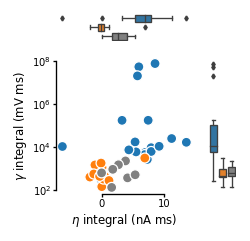

In [67]:
axes = jointplot(params_cleaned['eta_integral'], np.log10(params_cleaned['gamma_integral']))
axes['scatter_ax'].set_yticklabels(['$10^{{{:.0f}}}$'.format(y) for y in axes['scatter_ax'].get_yticks()])
axes['scatter_ax'].set_ylabel('$\gamma$ integral (mV ms)')
axes['scatter_ax'].set_xlabel('$\eta$ integral (nA ms)')

if IMG_PATH is not None:
    plt.savefig(os.path.join(IMG_PATH, 'joint_adaptation_params.png'))
    plt.savefig(os.path.join(IMG_PATH, 'joint_adaptation_params.svg'))

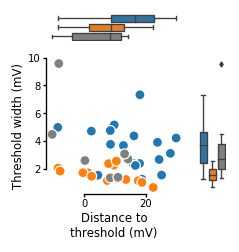

In [68]:
axes = jointplot(params_cleaned['thresh_dist'], params_cleaned['DV'])
axes['scatter_ax'].set_ylabel('Threshold width (mV)')
axes['scatter_ax'].set_xlabel('Distance to\nthreshold (mV)')

if IMG_PATH is not None:
    plt.savefig(os.path.join(IMG_PATH, 'joint_thresh_params.png'))
    plt.savefig(os.path.join(IMG_PATH, 'joint_thresh_params.svg'))

In [52]:
figsize=(1, 1.2)

p-value annotation legend:
ns: 1.00e-01 < p <= 1.00e+00
o: 5.00e-02 < p <= 1.00e-01
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04
()
thresh_dist_5HT v.s. thresh_dist_GABA: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=1.264e-01 U_stat=1.800e+02
thresh_dist_GABA v.s. thresh_dist_mPFC: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=1.000e+00 U_stat=5.600e+01
thresh_dist_5HT v.s. thresh_dist_mPFC: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=6.969e-02 U_stat=1.010e+02


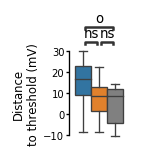

In [25]:
plt.figure(figsize=figsize)

gamma_ax = plt.subplot(111)
sns.boxplot(
    x='variable', y='value', hue='cell_type', 
    data=pd.concat([params_cleaned, cell_types], axis=1).melt(id_vars='cell_type'),
    order = ['thresh_dist'],
    hue_order=['5HT', 'GABA', 'mPFC'],
    palette=[colors['ser'], colors['som'], colors['pyr']],
    fliersize=2
)
add_stat_annotation(
    gamma_ax,
    x='variable', y='value', hue='cell_type', 
    data=pd.concat([params_cleaned, cell_types], axis=1).melt(id_vars='cell_type'),
    order = ['thresh_dist'],
    hue_order=['5HT', 'GABA', 'mPFC'],
    loc='outside',
    test='Mann-Whitney',
    comparisons_correction='bonferroni',
    pvalue_thresholds=pvalue_thresholds,
    box_pairs = [
        (('thresh_dist', '5HT'), ('thresh_dist', 'GABA')),
        (('thresh_dist', 'mPFC'), ('thresh_dist', 'GABA')),
        (('thresh_dist', '5HT'), ('thresh_dist', 'mPFC'))
    ]
)
plt.ylabel('Distance\nto threshold (mV)')
pltools.hide_border('trb', trim=True)
plt.xlabel('')
plt.xticks([])
plt.gca().get_legend().remove()

plt.subplots_adjust(left=0.45, top=0.7, bottom=0.05, right=0.95)

if IMG_PATH is not None:
    plt.savefig(os.path.join(IMG_PATH, 'thresh_dist.png'))
    plt.savefig(os.path.join(IMG_PATH, 'thresh_dist.svg'))

p-value annotation legend:
ns: 1.00e-01 < p <= 1.00e+00
o: 5.00e-02 < p <= 1.00e-01
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04
()
DV_5HT v.s. DV_GABA: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=6.374e-04 U_stat=2.240e+02
DV_GABA v.s. DV_mPFC: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=4.597e-02 U_stat=1.600e+01
DV_5HT v.s. DV_mPFC: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=1.000e+00 U_stat=7.300e+01


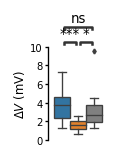

In [26]:
plt.figure(figsize=figsize)

gamma_ax = plt.subplot(111)
sns.boxplot(
    x='variable', y='value', hue='cell_type', 
    data=pd.concat([params_cleaned, cell_types], axis=1).melt(id_vars='cell_type'),
    order = ['DV'],
    hue_order=['5HT', 'GABA', 'mPFC'],
    palette=[colors['ser'], colors['som'], colors['pyr']],
    fliersize=2
)
add_stat_annotation(
    gamma_ax,
    x='variable', y='value', hue='cell_type', 
    data=pd.concat([params_cleaned, cell_types], axis=1).melt(id_vars='cell_type'),
    order = ['DV'],
    hue_order=['5HT', 'GABA', 'mPFC'],
    loc='outside',
    test='Mann-Whitney',
    comparisons_correction='bonferroni',
    pvalue_thresholds=pvalue_thresholds,
    box_pairs = [
        (('DV', '5HT'), ('DV', 'GABA')),
        (('DV', 'mPFC'), ('DV', 'GABA')),
        (('DV', '5HT'), ('DV', 'mPFC'))
    ]
)
plt.ylabel(r'$\Delta V$ (mV)')
plt.yticks([0, 2, 4, 6, 8, 10])
pltools.hide_border('trb', trim=True)
plt.xlabel('')
plt.xticks([])
plt.gca().get_legend().remove()

plt.subplots_adjust(left=0.45, top=0.7, bottom=0.05, right=0.95)

if IMG_PATH is not None:
    plt.savefig(os.path.join(IMG_PATH, 'thresh_width.png'))
    plt.savefig(os.path.join(IMG_PATH, 'thresh_width.svg'))

p-value annotation legend:
ns: 1.00e-01 < p <= 1.00e+00
o: 5.00e-02 < p <= 1.00e-01
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04
()
time_const_5HT v.s. time_const_GABA: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=6.374e-04 U_stat=2.240e+02
time_const_GABA v.s. time_const_mPFC: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=1.000e+00 U_stat=5.000e+01
time_const_5HT v.s. time_const_mPFC: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=3.031e-02 U_stat=1.060e+02


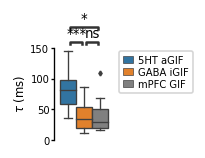

In [69]:
plt.figure(figsize=figsize)

gamma_ax = plt.subplot(111)
sns.boxplot(
    x='variable', y='value', hue='cell_type', 
    data=pd.concat([params_cleaned, cell_types], axis=1).melt(id_vars='cell_type'),
    order = ['time_const'],
    hue_order=['5HT', 'GABA', 'mPFC'],
    palette=[colors['ser'], colors['som'], colors['pyr']],
    fliersize=2
)
add_stat_annotation(
    gamma_ax,
    x='variable', y='value', hue='cell_type', 
    data=pd.concat([params_cleaned, cell_types], axis=1).melt(id_vars='cell_type'),
    order = ['time_const'],
    hue_order=['5HT', 'GABA', 'mPFC'],
    loc='outside',
    test='Mann-Whitney',
    comparisons_correction='bonferroni',
    pvalue_thresholds=pvalue_thresholds,
    box_pairs = [
        (('time_const', '5HT'), ('time_const', 'GABA')),
        (('time_const', 'mPFC'), ('time_const', 'GABA')),
        (('time_const', '5HT'), ('time_const', 'mPFC'))
    ]
)
plt.ylabel(r'$\tau$ (ms)')
plt.yticks([0, 50, 100, 150])
pltools.hide_border('trb', trim=True)
plt.xlabel('')
plt.xticks([])
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
legend_labels = plt.legend(bbox_to_anchor=(1, 1), loc='upper left').get_texts()
legend_labels[0].set_text(legend_labels[0].get_text() + ' aGIF')
legend_labels[1].set_text(legend_labels[1].get_text() + ' iGIF')
legend_labels[2].set_text(legend_labels[2].get_text() + ' GIF')

plt.subplots_adjust(left=0.45, top=0.7, bottom=0.05, right=0.95)

if IMG_PATH is not None:
    plt.savefig(os.path.join(IMG_PATH, 'time_const.png'))
    plt.savefig(os.path.join(IMG_PATH, 'time_const.svg'))

p-value annotation legend:
ns: 1.00e-01 < p <= 1.00e+00
o: 5.00e-02 < p <= 1.00e-01
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04
()
eta_integral_5HT v.s. eta_integral_GABA: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=5.483e-04 U_stat=2.250e+02
eta_integral_GABA v.s. eta_integral_mPFC: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=2.426e-02 U_stat=1.300e+01
eta_integral_5HT v.s. eta_integral_mPFC: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=2.123e-02 U_stat=1.080e+02


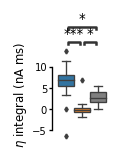

In [28]:
plt.figure(figsize=figsize)

eta_ax = plt.subplot(111)
sns.boxplot(
    x='variable', y='value', hue='cell_type', 
    data=pd.concat([params_cleaned, cell_types], axis=1).melt(id_vars='cell_type'),
    order = ['eta_integral'],
    hue_order=['5HT', 'GABA', 'mPFC'],
    palette=[colors['ser'], colors['som'], colors['pyr']],
    fliersize=2
)
add_stat_annotation(
    eta_ax,
    x='variable', y='value', hue='cell_type', 
    data=pd.concat([params_cleaned, cell_types], axis=1).melt(id_vars='cell_type'),
    order = ['eta_integral'],
    hue_order=['5HT', 'GABA', 'mPFC'],
    loc='outside',
    test='Mann-Whitney',
    comparisons_correction='bonferroni',
    pvalue_thresholds=pvalue_thresholds,
    box_pairs = [
        (('eta_integral', '5HT'), ('eta_integral', 'GABA')),
        (('eta_integral', 'mPFC'), ('eta_integral', 'GABA')),
        (('eta_integral', '5HT'), ('eta_integral', 'mPFC'))
    ]
)
plt.ylabel('$\eta$ integral (nA ms)')
pltools.hide_border('trb', trim=True)
plt.xlabel('')
plt.xticks([])
plt.gca().get_legend().remove()

plt.subplots_adjust(left=0.45, top=0.7, bottom=0.05, right=0.95)

if IMG_PATH is not None:
    plt.savefig(os.path.join(IMG_PATH, 'eta_integral.png'))
    plt.savefig(os.path.join(IMG_PATH, 'eta_integral.svg'))

Some 5HT neurons have **huge** moving thresholds. For clarity, we won't plot these.

In [29]:
assert all(params_cleaned['gamma_integral'] > 0)

p-value annotation legend:
ns: 1.00e-01 < p <= 1.00e+00
o: 5.00e-02 < p <= 1.00e-01
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04
()
gamma_integral_5HT v.s. gamma_integral_GABA: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=6.840e-05 U_stat=2.380e+02
gamma_integral_GABA v.s. gamma_integral_mPFC: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=1.000e+00 U_stat=4.200e+01
gamma_integral_5HT v.s. gamma_integral_mPFC: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=1.882e-03 U_stat=1.200e+02


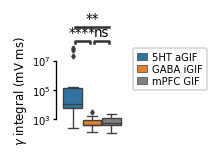

In [30]:
gamma_integrals = pd.concat([params_cleaned, cell_types], axis=1).melt(id_vars='cell_type')

plt.figure(figsize=(1.5, figsize[1]))

gamma_ax = plt.subplot(111)
gamma_ax.set_yscale('log')
sns.boxplot(
    x='variable', y='value', hue='cell_type', 
    data=gamma_integrals,
    order = ['gamma_integral'],
    hue_order=['5HT', 'GABA', 'mPFC'],
    palette=[colors['ser'], colors['som'], colors['pyr']],
    fliersize=2
)
add_stat_annotation(
    gamma_ax,
    x='variable', y='value', hue='cell_type', 
    data=gamma_integrals,
    order = ['gamma_integral'],
    hue_order=['5HT', 'GABA', 'mPFC'],
    loc='outside',
    test='Mann-Whitney',
    comparisons_correction='bonferroni',
    pvalue_thresholds=pvalue_thresholds,
    box_pairs = [
        (('gamma_integral', '5HT'), ('gamma_integral', 'GABA')),
        (('gamma_integral', 'mPFC'), ('gamma_integral', 'GABA')),
        (('gamma_integral', '5HT'), ('gamma_integral', 'mPFC'))
    ],
    line_height=0.5
)
plt.ylabel('$\gamma$ integral (mV ms)')
pltools.hide_border('trb', trim=True)
plt.xlabel('')
plt.xticks([])
pltools.hide_border('trb')
legend_labels = plt.legend(bbox_to_anchor=(1, 1), loc='upper left').get_texts()
legend_labels[0].set_text(legend_labels[0].get_text() + ' aGIF')
legend_labels[1].set_text(legend_labels[1].get_text() + ' iGIF')
legend_labels[2].set_text(legend_labels[2].get_text() + ' GIF')


plt.subplots_adjust(left=0.2, top=0.7, bottom=0.05, right=0.6)

if IMG_PATH is not None:
    plt.savefig(os.path.join(IMG_PATH, 'gamma_integral.png'))
    plt.savefig(os.path.join(IMG_PATH, 'gamma_integral.svg'))

p-value annotation legend:
ns: 1.00e-01 < p <= 1.00e+00
o: 5.00e-02 < p <= 1.00e-01
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04
()
gamma_integral_100_300_5HT v.s. gamma_integral_100_300_GABA: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=9.796e-06 U_stat=2.490e+02
gamma_integral_100_300_GABA v.s. gamma_integral_100_300_mPFC: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=1.441e-01 U_stat=7.600e+01
gamma_integral_100_300_5HT v.s. gamma_integral_100_300_mPFC: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=4.655e-04 U_stat=1.260e+02


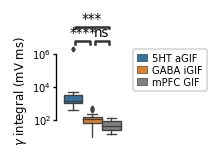

In [31]:
gamma_integrals = pd.concat([params_cleaned, cell_types], axis=1).melt(id_vars='cell_type')

plt.figure(figsize=(1.5, figsize[1]))

gamma_ax = plt.subplot(111)
gamma_ax.set_yscale('log')
sns.boxplot(
    x='variable', y='value', hue='cell_type', 
    data=gamma_integrals,
    order = ['gamma_integral_100_300'],
    hue_order=['5HT', 'GABA', 'mPFC'],
    palette=[colors['ser'], colors['som'], colors['pyr']],
    fliersize=2
)
add_stat_annotation(
    gamma_ax,
    x='variable', y='value', hue='cell_type', 
    data=gamma_integrals,
    order = ['gamma_integral_100_300'],
    hue_order=['5HT', 'GABA', 'mPFC'],
    loc='outside',
    test='Mann-Whitney',
    comparisons_correction='bonferroni',
    pvalue_thresholds=pvalue_thresholds,
    box_pairs = [
        (('gamma_integral_100_300', '5HT'), ('gamma_integral_100_300', 'GABA')),
        (('gamma_integral_100_300', 'mPFC'), ('gamma_integral_100_300', 'GABA')),
        (('gamma_integral_100_300', '5HT'), ('gamma_integral_100_300', 'mPFC'))
    ],
    line_height=0.5
)
plt.ylabel('$\gamma$ integral (mV ms)')
pltools.hide_border('trb', trim=True)
plt.xlabel('')
plt.xticks([])
pltools.hide_border('trb')
legend_labels = plt.legend(bbox_to_anchor=(1, 1), loc='upper left').get_texts()
legend_labels[0].set_text(legend_labels[0].get_text() + ' aGIF')
legend_labels[1].set_text(legend_labels[1].get_text() + ' iGIF')
legend_labels[2].set_text(legend_labels[2].get_text() + ' GIF')


plt.subplots_adjust(left=0.2, top=0.7, bottom=0.05, right=0.6)

if IMG_PATH is not None:
    plt.savefig(os.path.join(IMG_PATH, 'gamma_integral_100_300.png'))
    plt.savefig(os.path.join(IMG_PATH, 'gamma_integral_100_300.svg'))